In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dataset = torchvision.datasets.MNIST(root='./data', download = True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 50, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 108815006.52it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60811091.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32208583.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12742828.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



오토인코더 정의

In [ ]:
class Flatten(nn.Module): #4D -> 2D
  def forward(self,x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1) # (배치 수, 채널 수, 이미지 높이, 이미지 너비) -> (배치 수, 채널 수 * 이미지 너비 * 이미지 높이)

class Unflatten(nn.Module): #2D -> 4D
  def __init__(self, k):
    super().__init__()
    self.k = k
  def forward(self, x):
    s = x.size()
    #벡터 사이즈: 채널 수 * 이미지 너비 * 이미지 높이
    # -> 채널 수 * 이미지 사이즈**2 (너비와 높이가 같다는 가정 하)
    feature_size = int((s[1]//self.k)**0.5)
    return x.view(s[0], self.k, feature_size, feature_size)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    k = 16
    #MNIST는 흑백 이미지라 채널 수가 1! 고로 맨 앞 합성곱 layer의 입력 채널 수는 1
    self.encoder = nn.Sequential(nn.Conv2d(1,k,3,stride=2),
                                 nn.ReLU(),
                                 nn.Conv2d(k,2*k,3, stride=2),
                                 nn.ReLU(),
                                 nn.Conv2d(2*k,4*k,3,stride=1),
                                 nn.ReLU(),
                                 Flatten(),
                                 #Latent variables의 개수: 10개(이건 내 연구 목적에 맞게 변형해주면 됨)
                                 nn.Linear(1024,10),
                                 nn.ReLU())

    # ConvTranspose2d: 이미지의 사이즈를 늘리는, Upsampling할 때 쓰는 방법 (Conv2d는 이미지를 줄인다!)

    # 입력 성분(conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출한다.
    # 출력 된 벡터는 행렬 형태로 변환한다
    self.decoder = nn.Sequential(nn.Linear(10,1024),
                                 nn.ReLU(),
                                 Unflatten(4*k),
                                 nn.ConvTranspose2d(4*k,2*k,3,stride=1),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(2*k, k, 3, stride=2),
                                 nn.ReLU(),
                                 nn.ConvTranspose2d(k,1,3,stride=2,output_padding=1))

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

시각화 함수 만들기

In [ ]:
def normalize_output(img):
  img = (img - img.min()/(img.max()-img.min()))
  return img

def check_plot():
  with torch.no_grad():
    for data in trainloader:
      inputs = data[0].to(device)
      outputs = model(inputs)
      #imshow를 위한 순서로 변경해줌
      input_samples = inputs.permute(0,2,3,1).cpu().numpy() #원래 이미지
      reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() #생성 이미지
      break # 배치 하나만 받고 for문 종료

    #시각화 함수의 경우 normalization을 시켜줬을 경우 역으로 normalization 수행 해줘야함
    #여기선 그럴 필요 없으니 주석 처리

    #reconstructed_samples: normalized_output(reconstructed_samples) #0~1사이로 변환
    #input_sample도 동일한 연산 수행

    columns = 10 #시각화 전체 너비
    rows = 5 #시각화 전체 높이

    fig = plt.figure(figsize = (8,4))

    for i in range(1, columns*rows+1):
      img = input_samples[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img.squeeze())
      plt.axis('off')
    plt.show()

    fig = plt.figure(figsize = (8,4))

    for i in range(1,columns*rows*1):
      img = reconstructed_samples[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img.squeeze())
      plt.axis('off')
    plt.show()

In [ ]:
model=Autoencoder().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=1e-4)

[1] loss: 0.07251027365836005


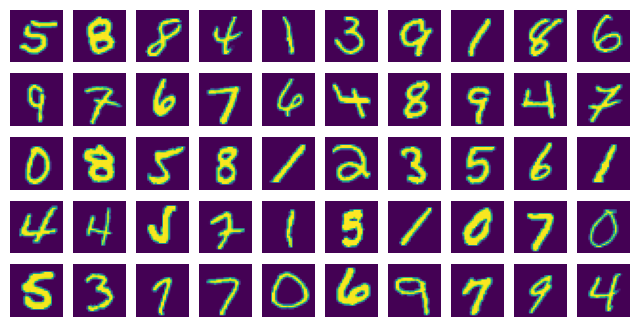

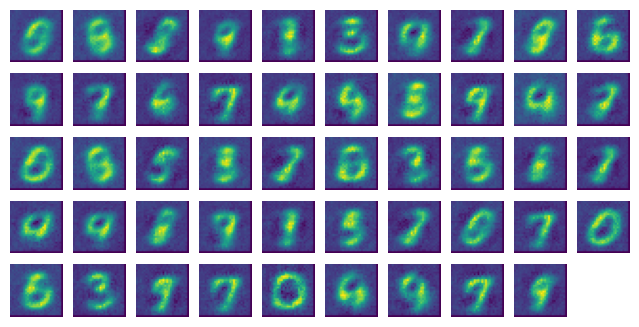

[11] loss: 0.027036782161643107


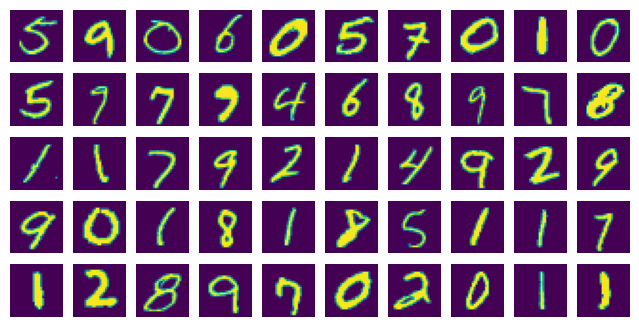

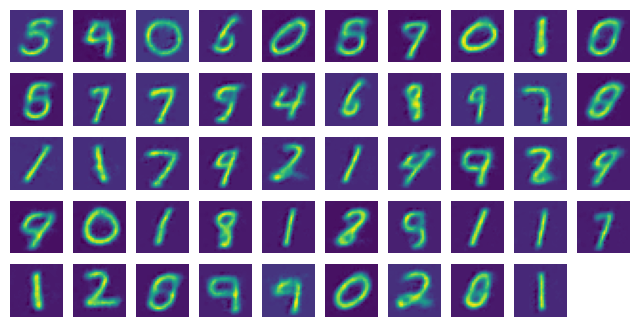

[21] loss: 0.024938072262642285


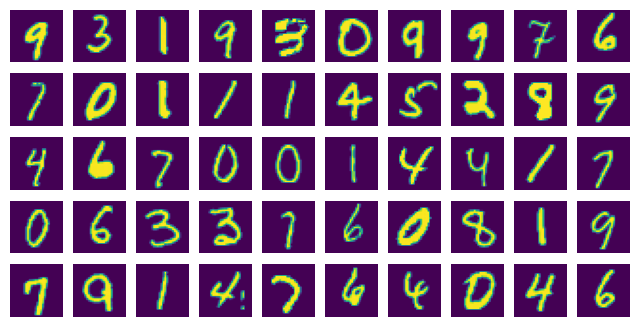

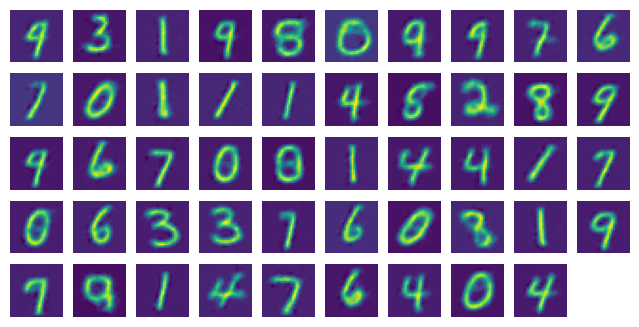

In [ ]:
for epoch in range(21):
  running_loss=0.0
  for data in trainloader:
    inputs = data[0].to(device)
    outputs = model(inputs)
    loss = criterion(inputs, outputs) #라벨 대신 입력 이미지와 출력 이미지를 비교
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  cost = running_loss/len(trainloader)

  if epoch%10 == 0:
    print(f'[{epoch+1}] loss: {cost}')
    check_plot()